In [100]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.metrics import accuracy_score
from keras import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, CuDNNLSTM, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [101]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')
DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/'
DATA = DIRECTORY + 'vehicle_data/' 

/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [102]:
df = pd.read_csv(DATA + 'records-sorted.csv')
df.head()

,record_id,timezone,created,modified,occurred_from,occurred_from_hour,occurred_to,lat,lon,location_text,...,weather,light,Severity,driverIncidentDetails_id,Main cause,Description,Collision type,Email of Encoder,Reporting Agency,Location Approximate
0,04660c01-6070-4e6e-850d-f2aeed151eb7,UTC,1/1/2019 12:55,1/1/2019 12:55,1/1/2019 7:01,7,1/1/2019 7:01,14.59961448,121.0495949,"Shell, Ortigas Avenue, Greenhills, West Crame,...",...,partly-cloudy-day,day,Property Damage,d271e8b3-155a-41d6-9226-02c99e97e782,Human error,NaN,Side-swipe,NaN,MMDA Metrobase,NaN
1,b1bb4e9e-981f-4101-87f7-86ac494c3719,UTC,1/1/2019 13:01,1/1/2019 13:01,1/1/2019 7:06,7,1/1/2019 7:06,14.5365323,120.9888697,"Diosdado Macapagal Boulevard, Metropolitan Par...",...,partly-cloudy-day,day,Property Damage,5a9bafeb-bf22-4d29-910d-19c349353d9b,Human error,NaN,Side-swipe,NaN,MMDA Metrobase,NaN
2,d12db962-0464-4944-b376-f993d272ee2b,UTC,1/1/2019 13:03,1/1/2019 13:03,1/1/2019 8:23,8,1/1/2019 8:23,14.63142389,121.0741425,"Katipunan Flyover, Escopa III, Project 4, Dist...",...,partly-cloudy-day,day,Property Damage,3b7fcdf1-c853-4699-95d2-49936f56875d,Human error,NaN,Side-swipe,NaN,MMDA Metrobase,NaN
3,adaee42b-288d-45a8-b2c2-f38ec2de1a88,UTC,1/1/2019 13:04,1/1/2019 13:04,1/1/2019 11:46,11,1/1/2019 11:46,14.63291873,121.044445,"Timog Avenue, Sacred Heart, Scout Area, Distri...",...,cloudy,night,Property Damage,fd14e79f-a6ea-4da4-98f7-3d8f5a1cb4d5,Human error,NaN,Other,NaN,MMDA Metrobase,NaN
4,7a4f2685-5f74-4bed-a3f4-9934f6469a87,UTC,1/1/2019 13:23,1/1/2019 13:23,1/1/2019 13:17,13,1/1/2019 13:17,14.62793588,121.0468483,"Pinagkaisahan Ecology Center, Ermin Garcia, Pi...",...,partly-cloudy-night,night,Property Damage,e34940fb-182f-4df0-83fb-9b1cbc2884f8,Human error,NaN,Other,NaN,MMDA Metrobase,NaN


In [103]:
df = df[['lat', 'lon', 'weather', 'light', 'Main cause', 'Collision type', 'occurred_from_hour', 'Severity' ]]
df = df.rename(columns={'Main cause': 'main_cause', 'Collision type': 'collision_type', 'occurred_from_hour' : 'occurred_from', 'Severity' : 'severity'})
df = df.iloc[:-1]

In [104]:
df.head()

,lat,lon,weather,light,main_cause,collision_type,occurred_from,severity
0,14.59961448,121.0495949,partly-cloudy-day,day,Human error,Side-swipe,7,Property Damage
1,14.5365323,120.9888697,partly-cloudy-day,day,Human error,Side-swipe,7,Property Damage
2,14.63142389,121.0741425,partly-cloudy-day,day,Human error,Side-swipe,8,Property Damage
3,14.63291873,121.044445,cloudy,night,Human error,Other,11,Property Damage
4,14.62793588,121.0468483,partly-cloudy-night,night,Human error,Other,13,Property Damage


In [105]:
df = df.dropna()
df.shape

(7736, 8)

In [106]:
df = df.iloc[:-1]
df

,lat,lon,weather,light,main_cause,collision_type,occurred_from,severity
0,14.59961448,121.0495949,partly-cloudy-day,day,Human error,Side-swipe,7,Property Damage
1,14.5365323,120.9888697,partly-cloudy-day,day,Human error,Side-swipe,7,Property Damage
2,14.63142389,121.0741425,partly-cloudy-day,day,Human error,Side-swipe,8,Property Damage
3,14.63291873,121.044445,cloudy,night,Human error,Other,11,Property Damage
4,14.62793588,121.0468483,partly-cloudy-night,night,Human error,Other,13,Property Damage
...,...,...,...,...,...,...,...,...
8279,14.59513962,121.0589933,clear-night,night,Human error,Other,19,Injury
8280,14.692686,121.0699153,clear-night,night,Human error,Other,19,Injury
8281,14.64420241,121.0376644,partly-cloudy-day,day,Human error,Side-swipe,23,Injury|Property Damage
8282,14.7051721,121.0755004,partly-cloudy-day,day,Human error,Side-swipe,0,Injury|Property Damage


In [107]:
df.dtypes

lat               object
lon               object
weather           object
light             object
main_cause        object
collision_type    object
occurred_from     object
severity          object
dtype: object

In [108]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [109]:
X

array([['14.59961448', '121.0495949', 'partly-cloudy-day', ...,
        'Human error', 'Side-swipe', '7'],
       ['14.5365323', '120.9888697', 'partly-cloudy-day', ...,
        'Human error', 'Side-swipe', '7'],
       ['14.63142389', '121.0741425', 'partly-cloudy-day', ...,
        'Human error', 'Side-swipe', '8'],
       ...,
       ['14.64420241', '121.0376644', 'partly-cloudy-day', ...,
        'Human error', 'Side-swipe', '23'],
       ['14.7051721', '121.0755004', 'partly-cloudy-day', ...,
        'Human error', 'Side-swipe', '0'],
       ['14.6003015', '120.9997391', 'partly-cloudy-day', ...,
        'Human error', 'Side-swipe', '1']], dtype=object)

In [110]:
y

array(['Property Damage', 'Property Damage', 'Property Damage', ...,
       'Injury|Property Damage', 'Injury|Property Damage',
       'Property Damage'], dtype=object)

In [111]:
df = pd.DataFrame(X, columns = ['lat', 'lon', 'weather', 'light', 'main_cause', 'collision_type', 'occurred_from'])
df

,lat,lon,weather,light,main_cause,collision_type,occurred_from
0,14.59961448,121.0495949,partly-cloudy-day,day,Human error,Side-swipe,7
1,14.5365323,120.9888697,partly-cloudy-day,day,Human error,Side-swipe,7
2,14.63142389,121.0741425,partly-cloudy-day,day,Human error,Side-swipe,8
3,14.63291873,121.044445,cloudy,night,Human error,Other,11
4,14.62793588,121.0468483,partly-cloudy-night,night,Human error,Other,13
...,...,...,...,...,...,...,...
7730,14.59513962,121.0589933,clear-night,night,Human error,Other,19
7731,14.692686,121.0699153,clear-night,night,Human error,Other,19
7732,14.64420241,121.0376644,partly-cloudy-day,day,Human error,Side-swipe,23
7733,14.7051721,121.0755004,partly-cloudy-day,day,Human error,Side-swipe,0


In [112]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['weather', 'light', 'main_cause'])], remainder='passthrough')
X = np.array(ct.fit_transform(df))


In [113]:
# assert 1 > 2

In [114]:
X[0]

array([0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,
       0.0, 0.0, 0.0, '14.59961448', '121.0495949', 'Side-swipe', '7'],
      dtype=object)

In [115]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [18])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [116]:
X[0]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       '14.59961448', '121.0495949', '7'], dtype=object)

In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[4 4 4 ... 3 3 4]


In [118]:
print(set(y))

{0, 1, 2, 3, 4}


In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [120]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [121]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [122]:
X_test

array([[0.        , 0.        , 0.        , ..., 0.66559885, 0.4459063 ,
        0.2173913 ],
       [0.        , 0.        , 0.        , ..., 0.43032988, 0.12528931,
        0.56521739],
       [0.        , 0.        , 0.        , ..., 0.67025407, 0.36277272,
        0.26086957],
       ...,
       [0.        , 0.        , 0.        , ..., 0.60692594, 0.54148672,
        0.95652174],
       [0.        , 0.        , 0.        , ..., 0.36732844, 0.45187827,
        0.08695652],
       [0.        , 0.        , 0.        , ..., 0.67325831, 0.33874856,
        0.47826087]])

In [123]:
X_train.shape

(6188, 29)

In [124]:
X_train.shape[1:]

(29,)

In [125]:
y_train.shape

(6188,)

In [126]:
y_train

array([4, 4, 4, ..., 4, 3, 4])

In [127]:
ann = tf.keras.models.Sequential()
ann.add(LSTM (32,  input_shape=(29,1), return_sequences=True)) 
ann.add(Dropout(0.2))

ann.add(LSTM (32, return_sequences=True)) 
ann.add(Dropout(0.2))

# ann.add(LSTM (50, return_sequences=True)) 
# ann.add(Dropout(0.2))

ann.add(LSTM (32)) 
ann.add(Dropout(0.2))

# remove this
# ann.add(Dense(32))
# ann.add(Dropout(0.2))
# ann.add(Activation('relu'))

ann.add(tf.keras.layers.Dense(units=5, activation='softmax'))



In [128]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.01)
ann.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [129]:
# from tensorflow.keras.optimizers import SGD
# opt = SGD(lr=0.2)
# ann.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [130]:
history = ann.fit(X_train, y_train, batch_size=8, epochs = 10, validation_split=0.1, verbose=1)

Epoch 1/10
697/697 [==============================] - 31s 37ms/step - loss: 0.3584 - accuracy: 0.9055 - val_loss: 0.3250 - val_accuracy: 0.9111
Epoch 2/10
697/697 [==============================] - 24s 35ms/step - loss: 0.3455 - accuracy: 0.9066 - val_loss: 0.3273 - val_accuracy: 0.9111
Epoch 3/10
697/697 [==============================] - 24s 35ms/step - loss: 0.3429 - accuracy: 0.9066 - val_loss: 0.3298 - val_accuracy: 0.9111
Epoch 4/10
697/697 [==============================] - 25s 35ms/step - loss: 0.3401 - accuracy: 0.9066 - val_loss: 0.3265 - val_accuracy: 0.9111
Epoch 5/10
697/697 [==============================] - 24s 35ms/step - loss: 0.3419 - accuracy: 0.9066 - val_loss: 0.3251 - val_accuracy: 0.9111
Epoch 6/10
697/697 [==============================] - 24s 35ms/step - loss: 0.3393 - accuracy: 0.9066 - val_loss: 0.3239 - val_accuracy: 0.9111
Epoch 7/10
697/697 [==============================] - 25s 35ms/step - loss: 0.3400 - accuracy: 0.9066 - val_loss: 0.3252 - val_accuracy:

In [131]:
ann.evaluate(X_test,y_test, batch_size=5)

310/310 [==============================] - 2s 7ms/step - loss: 0.3804 - accuracy: 0.8940


[0.3803819715976715, 0.8939883708953857]

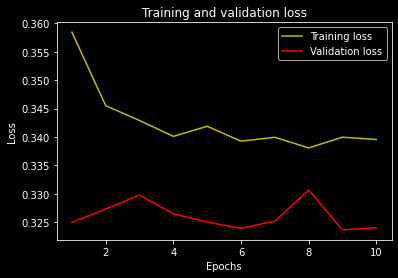

In [132]:
from matplotlib import pyplot as plt
plt.style.use('dark_background')
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

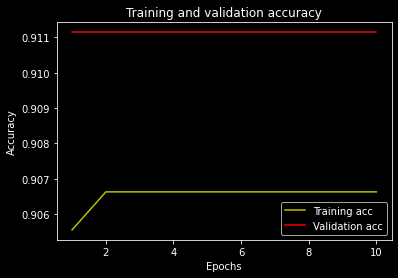

In [133]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [134]:
y_pred = ann.predict(X_test)
y_pred = np.amax(y_pred, axis=1)
y_pred

array([0.9100319 , 0.91031736, 0.9100305 , ..., 0.91066235, 0.91018087,
       0.9101081 ], dtype=float32)

In [135]:
y_pred = ann.predict(X_test, batch_size=100)
y_pred1D = y_pred.argmax(1)
print ('Accuracy on test data: ' + str(accuracy_score(y_test, y_pred1D)))

Accuracy on test data: 0.8939883645765999


In [136]:
assert 1 > 2

AssertionError: ignored

VALIDATION